In [38]:
# behave like a normal kernel plz
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot inline
%matplotlib inline

In [39]:
import pandas as pd
gene2pubmed = pd.read_table("data/genbank-data/gene2pubmed", sep = "\t")
list(gene2pubmed) # hmm.. the weird # in column header is going to come to bite me if I don't replace it right away !

gene2pubmed.rename(columns={'#tax_id':'tax_id'}, inplace=True)
list(gene2pubmed) # check name change

gene2pubmed.head()


['#tax_id', 'GeneID', 'PubMed_ID']

['tax_id', 'GeneID', 'PubMed_ID']

,tax_id,GeneID,PubMed_ID
0,9,1246500,9873079
1,9,1246501,9873079
2,9,1246502,9812361
3,9,1246502,9873079
4,9,1246503,9873079


In [40]:
merged_nodes = pd.read_table("new_taxdmp/merged.dmp", header=None, sep = "|", names=['old_tax_id','new_tax_id','empty'])
merged_nodes = merged_nodes.drop('empty', axis=1)
merged_nodes.head()
merged_nodes.shape

,old_tax_id,new_tax_id
0,12,74109
1,30,29
2,36,184914
3,37,42
4,46,39


(49365, 2)

In [41]:
# df.set_index('id')['value'].to_dict()
merged = merged_nodes.set_index('old_tax_id')['new_tax_id'].to_dict()
len(merged)

49365

In [42]:
# Replace gene2pubmed list of merged txid's
for txid in (gene2pubmed['tax_id']):
    if txid in merged:
        print("old " + str(txid))
        new = merged[txid]
        print("new " + str(new))
        gene2pubmed['tax_id'] =  gene2pubmed['tax_id'].replace([txid], new )

old 10857
new 2003327
old 12506
new 1980467
old 34582
new 1934733
old 35758
new 67581
old 78871
new 1828414
old 117575
new 1986029
old 175128
new 1763895
old 181418
new 1592441
old 390978
new 376820
old 415195
new 3171
old 745177
new 166921
old 984915
new 10989
old 1273087
new 1891718
old 1276187
new 1891722
old 1324794
new 1962300
old 1346162
new 1903492
old 1346828
new 1987479
old 1365206
new 1891756
old 1367205
new 58094
old 1479612
new 1972683
old 1608140
new 1980612


## Get list of taxid's to (a) get their lineage; (b) Restrict the list to bacteria and finally (c) subset gene2pubmed table to bacteria only entries

In [43]:
txidOnly = gene2pubmed.tax_id.unique()
type(txidOnly)
txidOnly[0:5] # have a peek
len(txidOnly) # number of tax_id's

numpy.ndarray

array([  9,  33, 139, 140, 158])

13950

If database is not indexed, do that to make sure queries process faster

In [44]:
#import sqlite3
#con = sqlite3.connect("NameNode.sqlite")
#cursor = con.cursor()

#index_db = ("CREATE INDEX tid ON NcbiNameNode(tax_id, name_class, name_txt);")
#cursor.execute(index_db)
#con.close()

In [45]:
# import sqlite3
# con = sqlite3.connect("NameNode.sqlite")
# cursor = con.cursor()
# 
# undetected = []
# Dummymaster = pd.DataFrame(columns=("species","genus","family","order","class","phylum","superkingdom","norank"))
# count = 0
# #txidtest = txidOnly[4948:5000]
# #for tid in txidtest:
# for tid in txidOnly:
#   ntid = int(tid)
# 
# #print(tid)
# df = pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == ? AND name_class == 'scientific name'", con=con, params = (ntid,))
# if df.size == 0:
#   #print(str(tid) + " check !!")
#   undetected.append(tid)
# count += 1
# continue
# print(str(count) + " number of tax_ids not found in database")

In [46]:
#undetected

In [47]:
#pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == 9 AND name_class == 'scientific name'", con=con)

In [48]:
import sqlite3
con = sqlite3.connect("NameNode.sqlite")   
Dummymaster = pd.DataFrame(columns=("species","genus","family","order","class","phylum","superkingdom","norank"))
count = 0
#txidtest = txidOnly[4948:5000]
#for tid in txidtest:
for tid in txidOnly:
    ntid = int(tid)
    
    #print(tid)
    df = pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == ? AND name_class == 'scientific name'", con=con, params = (ntid,))
    if df.size == 0:
        #print(str(tid) + " check !!")
        count += 1
        continue
    
    classi = {'taxid': tid,'species': 'unclassified','genus': 'unclassified','family': 'unclassified','order': 'unclassified','class': 'unclassified','phylum': 'unclassified','superkingdom': 'unclassified','norank': 'unclassified'}
    level = df['rank'][0]
    parent = df['parent_tax_id'][0]
    sciname = df['name_txt'][0]
    taxid = int(df['tax_id'][0])

    while parent != 1:
        #print(taxid)
        con = sqlite3.connect("NameNode.sqlite")
        df = pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == ? AND name_class == 'scientific name'", con = con, params=(taxid,))
        #con.close()
        #df
        
        level = df['rank'][0]
        parent = df['parent_tax_id'][0]
        sciname = df['name_txt'][0]
        #tax_id = df['tax_id'][0]
        taxid = int(df['parent_tax_id'][0])
        classi[level] = sciname
        #classi
    # df = pd.DataFrame.from_dict(sales)
    temp = pd.DataFrame.from_dict([classi])
    temp = temp[['taxid','species','genus','family','order','class','phylum','superkingdom','norank']]
    #temp
    #Dummymaster = Dummymaster.append(temp)
    Dummymaster = pd.concat([Dummymaster,temp],axis=0,join='outer')
    #Dummymaster
    

con.close()
Dummymaster = Dummymaster.reset_index()
Dummymaster[['taxid']] = Dummymaster[['taxid']].astype(int)
#list(Dummymaster)
Dummymaster= Dummymaster[['taxid','species','genus','family','order','class','phylum','superkingdom','norank']] 
print("number of unidentified taxid in db = " + str(count) )

Dummymaster.head()
Dummymaster.shape


number of unidentified taxid in db = 0


,taxid,species,genus,family,order,class,phylum,superkingdom,norank
0,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
1,33,Myxococcus fulvus,Myxococcus,Myxococcaceae,Myxococcales,Deltaproteobacteria,Proteobacteria,Bacteria,unclassified
2,139,Borreliella burgdorferi,Borreliella,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
3,140,Borrelia hermsii,Borrelia,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
4,158,Treponema denticola,Treponema,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified


(13950, 9)

## Identifying bacteria only

In [49]:
BacteriaOnly = Dummymaster.loc[(Dummymaster.superkingdom == 'Bacteria')]
BacteriaOnly.head()
BacteriaOnly.shape

,taxid,species,genus,family,order,class,phylum,superkingdom,norank
0,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
1,33,Myxococcus fulvus,Myxococcus,Myxococcaceae,Myxococcales,Deltaproteobacteria,Proteobacteria,Bacteria,unclassified
2,139,Borreliella burgdorferi,Borreliella,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
3,140,Borrelia hermsii,Borrelia,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
4,158,Treponema denticola,Treponema,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified


(1040, 9)

In [50]:
# pd.merge(df1, df2, on='column_name', how='inner')
BacteriaG2p= pd.merge(BacteriaOnly,gene2pubmed, left_on=['taxid'], right_on='tax_id', how='inner')
BacteriaG2p = BacteriaG2p.drop(['taxid'], axis = 1)
BacteriaG2p.head()
BacteriaG2p.shape

,species,genus,family,order,class,phylum,superkingdom,norank,tax_id,GeneID,PubMed_ID
0,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246500,9873079
1,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246501,9873079
2,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246502,9812361
3,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246502,9873079
4,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246503,9873079


(2104874, 11)

To save myself the pain of searching through gene descriptions manually, lets also upload the table of gene info

In [51]:
geneinfo = pd.read_table("data/genbank-data/gene_info_cut1-3_9-10", sep = "\t")
list(geneinfo) # darnit # in column header again !

geneinfo.rename(columns={'#tax_id':'tax_id'}, inplace=True)
list(geneinfo)

geneinfo.head()

['#tax_id', 'GeneID', 'Symbol', 'description', 'type_of_gene']

['tax_id', 'GeneID', 'Symbol', 'description', 'type_of_gene']

,tax_id,GeneID,Symbol,description,type_of_gene
0,7,5692769,NEWENTRY,Record to support submission of GeneRIFs for a...,other
1,9,1246500,repA1,putative replication-associated protein,protein-coding
2,9,1246501,repA2,putative replication-associated protein,protein-coding
3,9,1246502,leuA,2-isopropylmalate synthase,protein-coding
4,9,1246503,leuB,3-isopropylmalate dehydrogenase,protein-coding


In [52]:
BacteriaG2p_geneinfo = pd.merge(BacteriaG2p,geneinfo[['GeneID','Symbol','description','type_of_gene']], left_on='GeneID', right_on='GeneID', how='inner')
BacteriaG2p_geneinfo.shape

(2104873, 14)

In [53]:
BacteriaG2p_geneinfo.head()

,species,genus,family,order,class,phylum,superkingdom,norank,tax_id,GeneID,PubMed_ID,Symbol,description,type_of_gene
0,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246500,9873079,repA1,putative replication-associated protein,protein-coding
1,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246501,9873079,repA2,putative replication-associated protein,protein-coding
2,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246502,9812361,leuA,2-isopropylmalate synthase,protein-coding
3,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246502,9873079,leuA,2-isopropylmalate synthase,protein-coding
4,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,9,1246503,9873079,leuB,3-isopropylmalate dehydrogenase,protein-coding


## Most studied genes in Bacteria

In [54]:
BacteriaG2p_gene_gp_pubmedCount = BacteriaG2p_geneinfo.groupby('GeneID', as_index=False)['PubMed_ID'].agg({'PubMed_pubs': "count",'PubMed_uniqpubs': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
#BacteriaG2p_gene_gp_pubmedCount.head()
BacteriaG2p_gene_gp_pubmedCount2 = pd.merge(BacteriaG2p_gene_gp_pubmedCount, BacteriaG2p_geneinfo[['GeneID','Symbol','description']], on= 'GeneID', how='left')
#BacteriaG2p_gene_gp_pubmedCount2.head()
#BacteriaG2p_gene_gp_pubmedCount2.shape

BacteriaG2p_gene_gp_pubmedCount2 = BacteriaG2p_gene_gp_pubmedCount2.drop_duplicates()
#BacteriaG2p_gene_gp_pubmedCount2.head()
BacteriaG2p_gene_gp_pubmedCount2 = BacteriaG2p_gene_gp_pubmedCount2.reset_index(drop=True)
#BacteriaG2p_gene_gp_pubmedCount2.head()
#BacteriaG2p_gene_gp_pubmedCount2.shape

BacteriaG2p_gene_gp_pubmedCount2.sort_values('PubMed_pubs', ascending=False).head(n=10)
#BacteriaG2p_gene_gp_pubmedCount2.sort_values('PubMed_uniqpubs', ascending=False).head(n=10)


BacteriaG2p_gene_gp_pubmedCount2.sort_values('PubMed_pubs', ascending=False).tail(n=10)
#BacteriaG2p_gene_gp_pubmedCount2.sort_values('PubMed_uniqpubs', ascending=False).tail(n=10)

,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description
42993,948466,697,697,rrsB,16S ribosomal RNA of rrnB operon
42322,947777,678,678,rrsD,16S ribosomal RNA of rrnD operon
41642,947071,677,677,rrsG,16S ribosomal RNA of rrnG operon
43036,948511,677,677,rrsE,16S ribosomal RNA of rrnE operon
39536,944897,677,677,rrsH,16S ribosomal RNA of rrnH operon
42803,948270,676,676,rrsC,16S ribosomal RNA of rrnC operon
43000,948473,473,473,rrlB,23S ribosomal RNA of rrnB operon
42134,947585,457,457,rrlG,23S ribosomal RNA of rrnG operon
43034,948509,456,456,rrlE,23S ribosomal RNA of rrnE operon
42318,947773,454,454,rrlD,23S ribosomal RNA of rrnD operon


,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description
648298,23390444,1,1,SMDB11_RS20145,deacetylase
648297,23390443,1,1,SMDB11_RS20140,glycosyl transferase
648296,23390442,1,1,SMDB11_RS20135,glycosyl transferase
648295,23390441,1,1,SMDB11_RS20130,ligase
648294,23390440,1,1,SMDB11_RS20125,LPS biosynthesis protein
648293,23390439,1,1,SMDB11_RS20120,lipopolysaccharide heptosyltransferase 1
648292,23390438,1,1,SMDB11_RS20115,ADP-heptose--LPS heptosyltransferase
648291,23390437,1,1,SMDB11_RS20110,ADP-L-glycero-D-mannoheptose-6-epimerase
648290,23390436,1,1,SMDB11_RS20105,glycine C-acetyltransferase
1610996,36020782,1,1,GY21_RS16245,mannitol dehydrogenase family protein


In [55]:
# What types of gene descriptions do we have
BacteriaG2p_geneinfo.type_of_gene.unique()

array(['protein-coding', 'other', 'rRNA', 'pseudo', 'ncRNA', 'tRNA',
       'miscRNA'], dtype=object)

#### Lets see what non-rRNA genes or 'protein-coding' genes are most studied

In [56]:
BacteriaG2p_gene_gp_pubmedCount2_coding = pd.merge(BacteriaG2p_gene_gp_pubmedCount, BacteriaG2p_geneinfo[['GeneID','Symbol','description','type_of_gene']], on= 'GeneID', how='left')
# subset protein-coding only
# df.loc[df['column_name'] == some_value]
BacteriaG2p_gene_gp_pubmedCount2_coding = BacteriaG2p_gene_gp_pubmedCount2_coding.loc[BacteriaG2p_gene_gp_pubmedCount2_coding['type_of_gene'] == 'protein-coding']
BacteriaG2p_gene_gp_pubmedCount2_coding = BacteriaG2p_gene_gp_pubmedCount2_coding.drop_duplicates()
BacteriaG2p_gene_gp_pubmedCount2_coding = BacteriaG2p_gene_gp_pubmedCount2_coding.reset_index(drop=True)

#BacteriaG2p_gene_gp_pubmedCount2_coding.sort_values('PubMed_pubs', ascending=False).head(n=10)
BacteriaG2p_gene_gp_pubmedCount2_coding.sort_values('PubMed_uniqpubs', ascending=False).head(n=10)


#BacteriaG2p_gene_gp_pubmedCount2_coding.sort_values('PubMed_pubs', ascending=False).tail(n=10)
BacteriaG2p_gene_gp_pubmedCount2_coding.sort_values('PubMed_uniqpubs', ascending=False).tail(n=10)

,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description,type_of_gene
41594,947170,418,418,recA,DNA recombination and repair protein; ssDNA-de...,protein-coding
42798,948488,333,333,rpoB,"RNA polymerase, beta subunit",protein-coding
42558,948217,310,310,dnaA,chromosomal replication initiator protein DnaA...,protein-coding
39361,944750,309,309,dnaK,"chaperone Hsp70, with co-chaperone DnaJ",protein-coding
42228,947867,309,309,crp,"cAMP-activated global transcription factor, me...",protein-coding
39395,944786,297,297,ftsZ,GTP-binding tubulin-like cell division protein,protein-coding
41950,947567,291,291,rpoD,"RNA polymerase, sigma 70 (sigma D) factor",protein-coding
41629,947210,287,287,rpoS,"RNA polymerase, sigma S (sigma 38) factor",protein-coding
42797,948487,266,266,rpoC,"RNA polymerase, beta prime subunit",protein-coding
40341,945829,264,264,hns,global DNA-binding transcriptional dual regula...,protein-coding


,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description,type_of_gene
647852,23390626,1,1,SMDB11_RS21055,OsmC family protein,protein-coding
647851,23390625,1,1,SMDB11_RS21050,MarR family transcriptional regulator,protein-coding
647850,23390624,1,1,SMDB11_RS21045,GTP pyrophosphokinase,protein-coding
647849,23390623,1,1,SMDB11_RS21040,carbohydrate porin,protein-coding
647848,23390622,1,1,SMDB11_RS21035,6-phospho-beta-glucosidase,protein-coding
647847,23390621,1,1,SMDB11_RS21030,PTS beta-glucoside transporter subunit EIIBCA,protein-coding
647846,23390620,1,1,SMDB11_RS21025,3-oxoacyl-ACP reductase,protein-coding
647845,23390619,1,1,SMDB11_RS21020,LysR family transcriptional regulator,protein-coding
647844,23390618,1,1,SMDB11_RS21015,epimerase,protein-coding
1610372,36020782,1,1,GY21_RS16245,mannitol dehydrogenase family protein,protein-coding


#### Species ?

In [57]:
import numpy as np
#BacteriaG2p.head(n=2)

Bacteria_spp_pubmeduniqCount = BacteriaG2p.groupby('tax_id', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
#Bacteria_pubmedCount.head()

spp_pubmeduniqCountspp =  Bacteria_spp_pubmeduniqCount[['tax_id','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
spp_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (spp_pubmeduniqCountspp['Pubmed_uniqcount']/spp_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
#spp_pubmeduniqCountspp.head(n=10)
#totalpubmeduniqCountspp.tail(n=10)

spp_pubmeduniqCountspp2 = pd.merge(spp_pubmeduniqCountspp,BacteriaG2p[['tax_id','species']], on='tax_id', how='left')
spp_pubmeduniqCountspp2 = spp_pubmeduniqCountspp2.drop_duplicates()
spp_pubmeduniqCountspp2 = spp_pubmeduniqCountspp2.reset_index(drop=True)
spp_pubmeduniqCountspp2.head(n=10)
spp_pubmeduniqCountspp2.tail(n=10)

,tax_id,Pubmed_uniqcount,Pubmed_uniqCount_percent,species
0,511145,35636,53.549318,Escherichia coli
1,386585,3204,4.814570,Escherichia coli
2,224308,2395,3.598906,Bacillus subtilis
3,83332,1968,2.957264,Mycobacterium tuberculosis
4,99287,1557,2.339665,Salmonella enterica
5,208964,1519,2.282563,Pseudomonas aeruginosa
6,562,974,1.463605,Escherichia coli
7,300852,719,1.080423,Thermus thermophilus
8,198214,668,1.003787,Shigella flexneri
9,100226,656,0.985755,Streptomyces coelicolor


,tax_id,Pubmed_uniqcount,Pubmed_uniqCount_percent,species
1030,212717,1,0.001503,Clostridium tetani
1031,218495,1,0.001503,Streptococcus uberis
1032,251747,1,0.001503,Chromobacterium subtsugae
1033,223967,1,0.001503,Methylobacterium populi
1034,225937,1,0.001503,Marinobacter adhaerens
1035,237610,1,0.001503,Pseudomonas psychrotolerans
1036,238013,1,0.001503,Lactobacillus rennini
1037,33,1,0.001503,Myxococcus fulvus
1038,246432,1,0.001503,Staphylococcus equorum
1039,1855823,1,0.001503,Macrococcus canis


species,Escherichia coli,Escherichia coli,Bacillus subtilis,Mycobacterium tuberculosis,Salmonella enterica,Pseudomonas aeruginosa,Escherichia coli,Thermus thermophilus,Shigella flexneri,Streptomyces coelicolor
Pubmed_uniqCount_percent,53.549318,4.81457,3.598906,2.957264,2.339665,2.282563,1.463605,1.080423,1.003787,0.985755


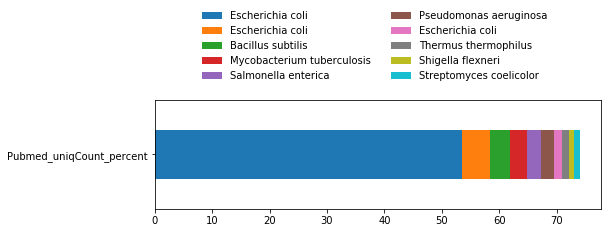

In [66]:
import numpy as np
totalpubmeduniqCountspp =  spp_pubmeduniqCountspp2[['tax_id','Pubmed_uniqcount','species']].sort_values('Pubmed_uniqcount', ascending=False)
totalpubmeduniqCountspp['Pubmed_uniqCount_percent'] = (totalpubmeduniqCountspp['Pubmed_uniqcount']/totalpubmeduniqCountspp['Pubmed_uniqcount'].sum())*100


import matplotlib.pyplot as plt
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['species','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head(n=10).set_index('species').T
test
#fig, ax = subplots()
ax = test.plot.barh(stacked=True, width = 0.4,figsize = (8,2))
#ax.legend(frameon= False, ncol=2)
ax.legend(loc='center right', bbox_to_anchor=(0.9,1.5), ncol=2, frameon=False) # center left

species,Escherichia coli,Escherichia coli,Bacillus subtilis,Mycobacterium tuberculosis,Salmonella enterica,Pseudomonas aeruginosa,Escherichia coli,Thermus thermophilus,Shigella flexneri,Streptomyces coelicolor
Pubmed_uniqCount_percent,53.549318,4.81457,3.598906,2.957264,2.339665,2.282563,1.463605,1.080423,1.003787,0.985755


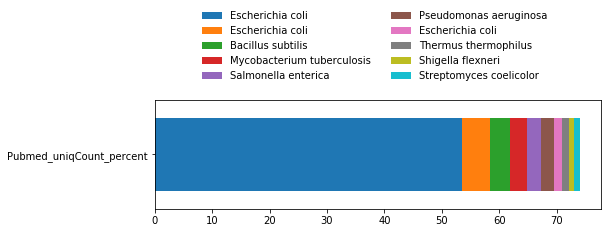

In [72]:
import numpy as np
totalpubmeduniqCountspp =  spp_pubmeduniqCountspp2[['tax_id','Pubmed_uniqcount','species']].sort_values('Pubmed_uniqcount', ascending=False)
totalpubmeduniqCountspp['Pubmed_uniqCount_percent'] = (totalpubmeduniqCountspp['Pubmed_uniqcount']/totalpubmeduniqCountspp['Pubmed_uniqcount'].sum())*100


import matplotlib.pyplot as plt
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['species','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head(n=10).set_index('species').T
test
#fig, ax = subplots()
ax = test.plot.barh(stacked=True, width = 1,figsize = (8,2))
#ax.legend(frameon= False, ncol=2)
ax.legend(loc='center right', bbox_to_anchor=(0.9,1.5), ncol=2, frameon=False) # center left

In [58]:
## 349741 #Akkermansia muciniphila

#Akkermansia_muciniphila = BacteriaG2p.loc[(BacteriaG2p.tax_id == 349741)]
#Akkermansia_muciniphila = Akkermansia_muciniphila.drop_duplicates()
#Akkermansia_muciniphila = Akkermansia_muciniphila.reset_index(drop=True)
#Akkermansia_muciniphila

#### Genus

In [59]:
import numpy as np

Bacteria_genus_pubmeduniqCount = BacteriaG2p.groupby('genus', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted

genus_pubmeduniqCountspp =  Bacteria_genus_pubmeduniqCount[['genus','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
genus_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (genus_pubmeduniqCountspp['Pubmed_uniqcount']/genus_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
genus_pubmeduniqCountspp.head(n=10)
genus_pubmeduniqCountspp.tail(n=10)

round((genus_pubmeduniqCountspp['Pubmed_uniqCount_percent'].sum()),1)

#genus_pubmeduniqCountspp2 = pd.merge(genus_pubmeduniqCountspp,BacteriaG2p[['genus','genus']], on='tax_id', how='left')
#genus_pubmeduniqCountspp2 = genus_pubmeduniqCountspp2.drop_duplicates()
#genus_pubmeduniqCountspp2 = genus_pubmeduniqCountspp2.reset_index(drop=True)
#genus_pubmeduniqCountspp2.head(n=10)
#genus_pubmeduniqCountspp2.tail(n=10)

,genus,Pubmed_uniqcount,Pubmed_uniqCount_percent
81,Escherichia,37141,60.192208
24,Bacillus,3039,4.925126
147,Mycobacterium,2442,3.957604
187,Pseudomonas,2326,3.769610
207,Salmonella,1847,2.993323
223,Streptococcus,965,1.563918
220,Staphylococcus,848,1.374303
224,Streptomyces,796,1.290030
211,Shigella,765,1.239790
238,Thermus,720,1.166861


,genus,Pubmed_uniqcount,Pubmed_uniqCount_percent
192,Raoultella,1,0.001621
101,Gordonia,1,0.001621
77,Ensifer,1,0.001621
83,Faecalibacterium,1,0.001621
86,Fischerella,1,0.001621
88,Fluoribacter,1,0.001621
91,Frigoribacterium,1,0.001621
178,Pluralibacter,1,0.001621
93,Gallibacterium,1,0.001621
127,Lonsdalea,1,0.001621


100.0

genus,Escherichia,Bacillus,Mycobacterium,Pseudomonas,Salmonella,Streptococcus,Staphylococcus,Streptomyces,Shigella,Thermus
Pubmed_uniqCount_percent,60.192208,4.925126,3.957604,3.76961,2.993323,1.563918,1.374303,1.29003,1.23979,1.166861


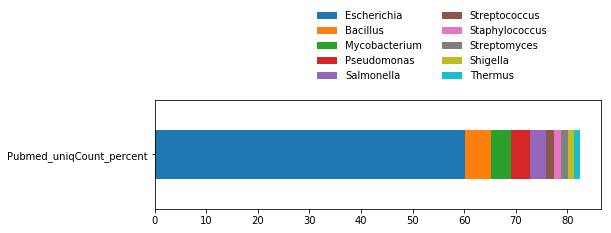

In [69]:
import numpy as np
totalpubmeduniqCountspp =  genus_pubmeduniqCountspp[['Pubmed_uniqcount','genus']].sort_values('Pubmed_uniqcount', ascending=False)
totalpubmeduniqCountspp['Pubmed_uniqCount_percent'] = (totalpubmeduniqCountspp['Pubmed_uniqcount']/totalpubmeduniqCountspp['Pubmed_uniqcount'].sum())*100


import matplotlib.pyplot as plt
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['genus','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head(n=10).set_index('genus').T
test
#fig, ax = subplots()
ax = test.plot.barh(stacked=True, width = 0.4,figsize = (8,2))
#ax.legend(frameon= False, ncol=2)
ax.legend(loc='center right', bbox_to_anchor=(0.9,1.5), ncol=2, frameon=False) # center left

In [60]:
import numpy as np

Bacteria_family_pubmeduniqCount = BacteriaG2p.groupby('family', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
#Bacteria_pubmedCount.head()

family_pubmeduniqCountspp =  Bacteria_family_pubmeduniqCount[['family','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
family_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (family_pubmeduniqCountspp['Pubmed_uniqcount']/family_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
family_pubmeduniqCountspp.head(n=10)
family_pubmeduniqCountspp.tail(n=10)

round((family_pubmeduniqCountspp['Pubmed_uniqCount_percent'].sum()),1)


,family,Pubmed_uniqcount,Pubmed_uniqCount_percent
39,Enterobacteriaceae,39198,64.585118
12,Bacillaceae,3058,5.038555
73,Mycobacteriaceae,2442,4.023595
96,Pseudomonadaceae,2326,3.832466
112,Streptococcaceae,1318,2.171621
111,Staphylococcaceae,849,1.398866
113,Streptomycetaceae,805,1.326369
117,Thermaceae,720,1.186318
122,Vibrionaceae,713,1.174784
98,Rhizobiaceae,688,1.133593


,family,Pubmed_uniqcount,Pubmed_uniqCount_percent
115,Synergistaceae,1,0.001648
54,Hapalosiphonaceae,1,0.001648
22,Carnobacteriaceae,1,0.001648
24,Cellvibrionaceae,1,0.001648
61,Leptotrichiaceae,1,0.001648
70,Microscillaceae,1,0.001648
30,Clostridiales Family XVII. Incertae Sedis,1,0.001648
43,Fastidiosibacteraceae,1,0.001648
41,Entomoplasmataceae,1,0.001648
38,Dictyoglomaceae,1,0.001648


100.0

In [61]:
import numpy as np

Bacteria_order_pubmeduniqCount = BacteriaG2p.groupby('order', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
#Bacteria_pubmedCount.head()

order_pubmeduniqCountspp =  Bacteria_order_pubmeduniqCount[['order','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
order_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (order_pubmeduniqCountspp['Pubmed_uniqcount']/order_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
order_pubmeduniqCountspp.head(n=10)
order_pubmeduniqCountspp.tail(n=10)

round((order_pubmeduniqCountspp['Pubmed_uniqCount_percent'].sum()),1)


,order,Pubmed_uniqcount,Pubmed_uniqCount_percent
26,Enterobacterales,39710,65.492389
6,Bacillales,4199,6.925272
19,Corynebacteriales,2799,4.616298
49,Pseudomonadales,2452,4.044002
33,Lactobacillales,2025,3.339765
51,Rhizobiales,945,1.558557
59,Streptomycetales,805,1.327660
62,Thermales,720,1.187472
69,Vibrionales,713,1.175927
11,Campylobacterales,687,1.133046


,order,Pubmed_uniqcount,Pubmed_uniqCount_percent
47,Planctomycetales,2,0.003299
41,Nitrospirales,2,0.003299
56,Sphingobacteriales,2,0.003299
20,Cytophagales,1,0.001649
13,Cellvibrionales,1,0.001649
25,Dictyoglomales,1,0.001649
68,Verrucomicrobiales,1,0.001649
38,Myxococcales,1,0.001649
40,Nitrosomonadales,1,0.001649
61,Synergistales,1,0.001649


100.0

In [62]:
import numpy as np

Bacteria_class_pubmeduniqCount = BacteriaG2p.groupby('class', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
#Bacteria_pubmedCount.head()

class_pubmeduniqCountspp =  Bacteria_class_pubmeduniqCount[['class','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
class_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (class_pubmeduniqCountspp['Pubmed_uniqcount']/class_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
class_pubmeduniqCountspp.head(n=10)
class_pubmeduniqCountspp.tail(n=10)

round((class_pubmeduniqCountspp['Pubmed_uniqCount_percent'].sum()),1)


,class,Pubmed_uniqcount,Pubmed_uniqCount_percent
20,Gammaproteobacteria,43620,72.144487
4,Bacilli,6210,10.270914
1,Actinobacteria,3763,6.223744
2,Alphaproteobacteria,1811,2.995270
6,Betaproteobacteria,1048,1.733320
13,Deinococci,872,1.442228
16,Epsilonproteobacteria,687,1.136251
27,Spirochaetia,463,0.765770
29,Thermotogae,416,0.688035
10,Clostridia,395,0.653303


,class,Pubmed_uniqcount,Pubmed_uniqCount_percent
12,Dehalococcoidia,5,0.008270
0,Acidithiobacillia,5,0.008270
24,Nitrospira,2,0.003308
25,Planctomycetia,2,0.003308
26,Sphingobacteriia,2,0.003308
30,Tissierellia,2,0.003308
11,Cytophagia,1,0.001654
28,Synergistia,1,0.001654
15,Dictyoglomia,1,0.001654
31,Verrucomicrobiae,1,0.001654


100.0

In [63]:
import numpy as np

Bacteria_phylum_pubmeduniqCount = BacteriaG2p.groupby('phylum', as_index=False)['PubMed_ID'].agg({'Pubmed_count': "count",'Pubmed_uniqcount': 'nunique'}) # because pandas preserves the row index and we need it reset to be sorted
#Bacteria_pubmedCount.head()

phylum_pubmeduniqCountspp =  Bacteria_phylum_pubmeduniqCount[['phylum','Pubmed_uniqcount']].sort_values('Pubmed_uniqcount', ascending=False)
phylum_pubmeduniqCountspp['Pubmed_uniqCount_percent'] = (phylum_pubmeduniqCountspp['Pubmed_uniqcount']/phylum_pubmeduniqCountspp['Pubmed_uniqcount'].sum())*100
phylum_pubmeduniqCountspp.head(n=10)
phylum_pubmeduniqCountspp.tail(n=10)

round((phylum_pubmeduniqCountspp['Pubmed_uniqCount_percent'].sum()),1)


,phylum,Pubmed_uniqcount,Pubmed_uniqCount_percent
14,Proteobacteria,47234,78.256403
10,Firmicutes,6612,10.954637
0,Actinobacteria,3763,6.234468
7,Deinococcus-Thermus,872,1.444713
15,Spirochaetes,463,0.767090
18,Thermotogae,416,0.689221
3,Chlamydiae,219,0.362835
17,Tenericutes,185,0.306505
2,Bacteroidetes,172,0.284966
6,Cyanobacteria,152,0.251831


,phylum,Pubmed_uniqcount,Pubmed_uniqCount_percent
4,Chlorobi,50,0.082839
5,Chloroflexi,37,0.061301
11,Fusobacteria,16,0.026508
9,Fibrobacteres,12,0.019881
20,unclassified,6,0.009941
13,Planctomycetes,2,0.003314
12,Nitrospirae,2,0.003314
16,Synergistetes,1,0.001657
8,Dictyoglomi,1,0.001657
19,Verrucomicrobia,1,0.001657


100.0